---
format:
  html:
    code-line-numbers: true
    code-overflow: wrap
    code-block-bg: true
    code-block-border-left: true
    highlight-style: Arrow
---

# Traveling Salesman Problem {#sec-ip-tsp}

The traveling salesman problem (TSP) is a classic optimization problem in computer science and operations research. The problem can be stated as follows: given a set of cities and the distances between them, what is the shortest possible route that visits each city exactly once and returns to the starting city?

The TSP has many real-world applications, including logistics and transportation planning, circuit board drilling, and DNA sequencing.
However, it is a well-known NP-hard problem, meaning that finding an optimal solution is computationally difficult for large instances of the problem. 
As a result, many heuristic and approximation algorithms have been developed to find suboptimal solutions that are still very good in practice.
In this chapter, we present several mathematical formulations of the TSP existing in the literature and implement them using OR-Tools.

## TSP Instances

Before discussing the mathematical models of the TSP, we first provide an introduction to the instances that will be utilized to test various formulations and illustrate the resulting TSP solutions. 
The TSP is a widely recognized optimization problem that has been studied for several decades. 
Due to its significance, many benchmarking problem instances of varying sizes are available in literature. 
In this chapter, we do not aim to solve the most challenging TSP instances, but instead, our objective is to demonstrate how to apply different formulations of the TSP using OR-Tools.

To achieve this objective, we will focus on presenting some of the small-sized instances that can be solved effectively using OR-Tools. 
These instances are well-documented, which makes them easy to understand and implement in practice. Additionally, they help illustrate the optimization techniques used to solve the TSP, such as branch-and-bound and cutting plane methods. 
Moreover, small-sized instances allow for quicker computation, making it easier to observe the behavior of different algorithms and identify which formulations are most efficient.

By presenting a range of examples, we aim to provide a clear understanding of how to implement different TSP formulations using OR-Tools, which can be applied to real-world problems in various domains, such as transportation planning and logistics, network design, and circuit board drilling. 
Additionally, we aim to demonstrate the advantages and limitations of different TSP formulations and algorithms, highlighting which techniques perform well under specific circumstances. 
By doing so, readers can gain insight into how to apply TSP optimization techniques to their own problems effectively.

### TSPLIB

The TSP instances used in this section are sourced from [TSPLIB95](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/), a library of TSP benchmark instances. 
To make it easier to work with these instances, we utilize the `tsplib95` Python library, which can be installed using the `pip install tsplib95` command.

In the code snippet below, we demonstrate how to use the `tsplib95` package to load the *ulysses22.tsp* problem from a data file downloaded from TSPLIB95. 
The loaded data can be used to formulate and solve TSP instances using OR-Tools or other optimization tools. The full instance data is provided at the end for reference.
 By leveraging the `tsplib95` package, we can quickly and easily access TSP instances for experimentation and analysis, and focus our efforts on the formulation and optimization aspects of the problem.

In [1]:
import tsplib95

# load problem
problem = tsplib95.load('./data/tsp/ulysses22.tsp')

# show instance
problem.as_name_dict()

{'name': 'ulysses22.tsp',
 'comment': 'Odyssey of Ulysses (Groetschel/Padberg)',
 'type': 'TSP',
 'dimension': 22,
 'edge_weight_type': 'GEO',
 'display_data_type': 'COORD_DISPLAY',
 'node_coords': {1: [38.24, 20.42],
  2: [39.57, 26.15],
  3: [40.56, 25.32],
  4: [36.26, 23.12],
  5: [33.48, 10.54],
  6: [37.56, 12.19],
  7: [38.42, 13.11],
  8: [37.52, 20.44],
  9: [41.23, 9.1],
  10: [41.17, 13.05],
  11: [36.08, -5.21],
  12: [38.47, 15.13],
  13: [38.15, 15.35],
  14: [37.51, 15.17],
  15: [35.49, 14.32],
  16: [39.36, 19.56],
  17: [38.09, 24.36],
  18: [36.09, 23.0],
  19: [40.44, 13.57],
  20: [40.33, 14.15],
  21: [40.37, 14.23],
  22: [37.57, 22.56]}}

The list of nodes can be retrieved using the `get_nodes()` function, as shown below.

In [2]:
list(problem.get_nodes())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

To get the distance between any pair of nodes, we use the `get_weight()` function.

In [3]:
print(f'distance between node 1 and 2 = {problem.get_weight(1, 2)}')

distance between node 1 and 2 = 509


### Visualize TSP Solution



In this section, our goal is to gain a better understanding of the TSP problem by visualizing the optimal solution found for instances provided by TSPLIB95. 
To achieve this, we define a class called `TspVisualizer` in our code that is responsible for displaying the route that connects all nodes in a TSP solution. 
The `TspVisualizer` class contains a single function, called `show(locations, edges)`, which accepts two input parameters: *locations* and *edges*.

The *locations* parameter is a dictionary that contains the mapping between location ID and its corresponding coordinates. 
The *edges* parameter is a list of edges that form the TSP tour. 
By calling the show function with the appropriate input parameters, we can visualize the TSP tour and gain an intuitive understanding of what the TSP problem is trying to accomplish. 
This visualization can be a helpful tool in understanding how the different TSP formulations and algorithms work, and can aid in identifying potential improvements to the solution. 
The use of the `TspVisualizer` class allows for easy visualization of the TSP solution and makes it possible to explore and analyze TSP instances in a more meaningful way.

In [4]:
#| code-line-numbers: true

import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class TspVisualizer:
    """visualize a TSP tour
    """
    
    @staticmethod
    def show(locations, edges):
        """draw TSP tour
        adapted from https://stackoverflow.com/a/50682819
        
        examples:
        locations = {
            0: (5, 5),
            1: (4, 9),
            2: (6, 4),
        }

        edges = [
            (0, 1),
            (1, 2),
            (2, 0),
        ]

        Args:
            locations (dict): location id -> (lat, lon)
            edges (list): list of edges
        """
        G = nx.DiGraph()
        G.add_edges_from(edges)
        plt.figure(figsize=(15,10))
        
        colors = mpl.colormaps["Set1"].colors
        color_idx = 1
        color = np.array([colors[color_idx]])
        
        nx.draw_networkx_nodes(G, 
                                locations, 
                                nodelist=[x[0] 
                                        for x in edges], 
                                node_color=color)
        nx.draw_networkx_edges(G,
                                locations, 
                                edgelist=edges,
                                width=4, 
                                edge_color=color, 
                                style='dashed')
        
        # labels
        nx.draw_networkx_labels(G, locations, 
                                font_color='w', 
                                font_size=12, 
                                font_family='sans-serif')

        #print out the graph
        plt.axis('off')
        plt.show()

Now let's load the optimal solution for the aforementioned instance and show its content below.

In [5]:
solution = tsplib95.load('./data/tsp/ulysses22.opt.tour')
solution.as_name_dict()

{'name': 'ulysses22.opt.tour',
 'comment': 'Optimal solution of ulysses22 (7013)',
 'type': 'TOUR',
 'dimension': 22,
 'tours': [[1,
   14,
   13,
   12,
   7,
   6,
   15,
   5,
   11,
   9,
   10,
   19,
   20,
   21,
   16,
   3,
   2,
   17,
   22,
   4,
   18,
   8]]}

The code snippet below plots the optimal tour, which is shown in @fig-tsp-ulysses22-sol.

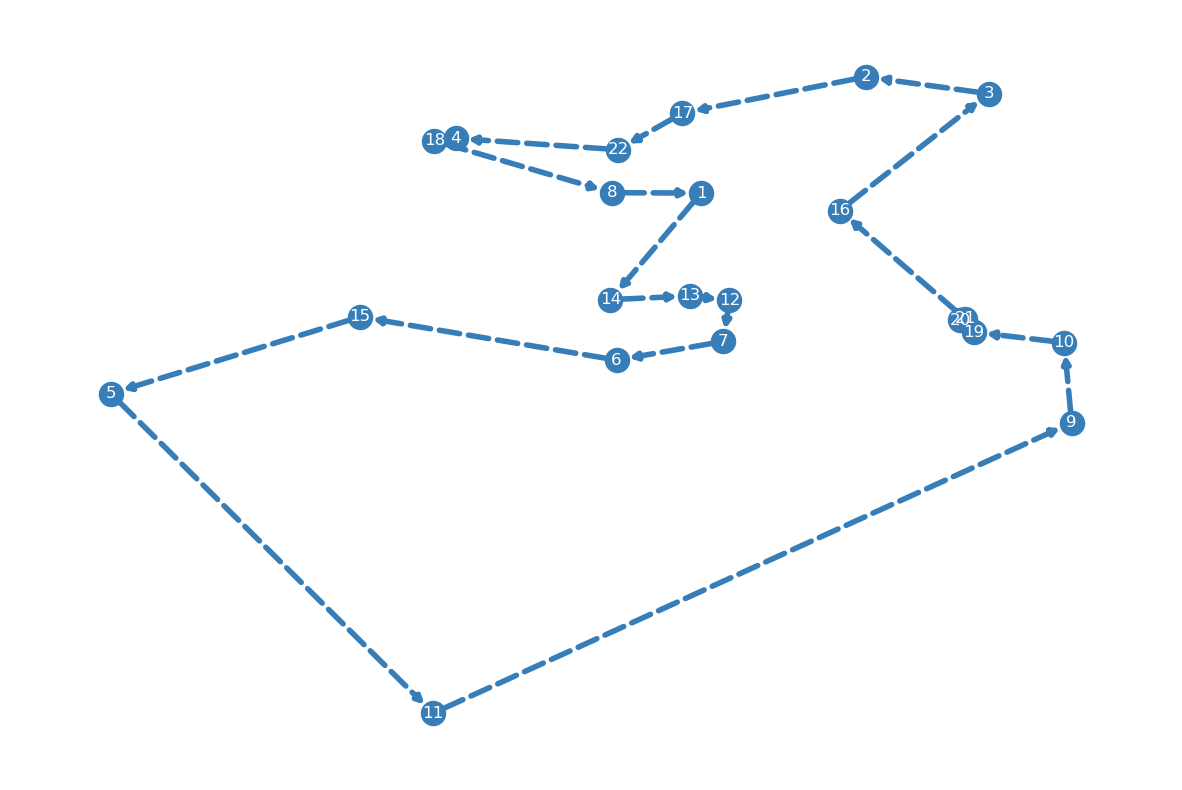

In [6]:
#| echo: true
#| code-line-numbers: true
#| label: fig-tsp-ulysses22-sol
#| fig-cap: Optimal tour of the *ulysses22* instance

locations = problem.node_coords
tour = solution.tours[0]
edges = []
for i in range(len(tour) - 1):
    edges.append((tour[i], tour[i + 1]))
edges.append((tour[-1], tour[0]))
edges = []
for i in range(len(tour) - 1):
    edges.append((tour[i], tour[i + 1]))
edges.append((tour[-1], tour[0]))
TspVisualizer.show(locations, edges)

Let's put this visualization procedure into a dedicated function, as is given below.

In [7]:
import tsplib95

def visualize_tsp(instance_name: str):
    # load problem
    problem = tsplib95.load(f'./data/tsp/{instance_name}.tsp')
    solution = tsplib95.load(f'./data/tsp/{instance_name}.opt.tour')

    locations = problem.node_coords
    tour = solution.tours[0]
    edges = []
    for i in range(len(tour) - 1):
        edges.append((tour[i], tour[i + 1]))
    edges.append((tour[-1], tour[0]))
    edges = []
    for i in range(len(tour) - 1):
        edges.append((tour[i], tour[i + 1]))
    edges.append((tour[-1], tour[0]))
    TspVisualizer.show(locations, edges)

@fig-tsp-berlin52-sol and @fig-tsp-pr76-sol show the optimal tours for the *berlin52* and *pr76* instances, respectively.

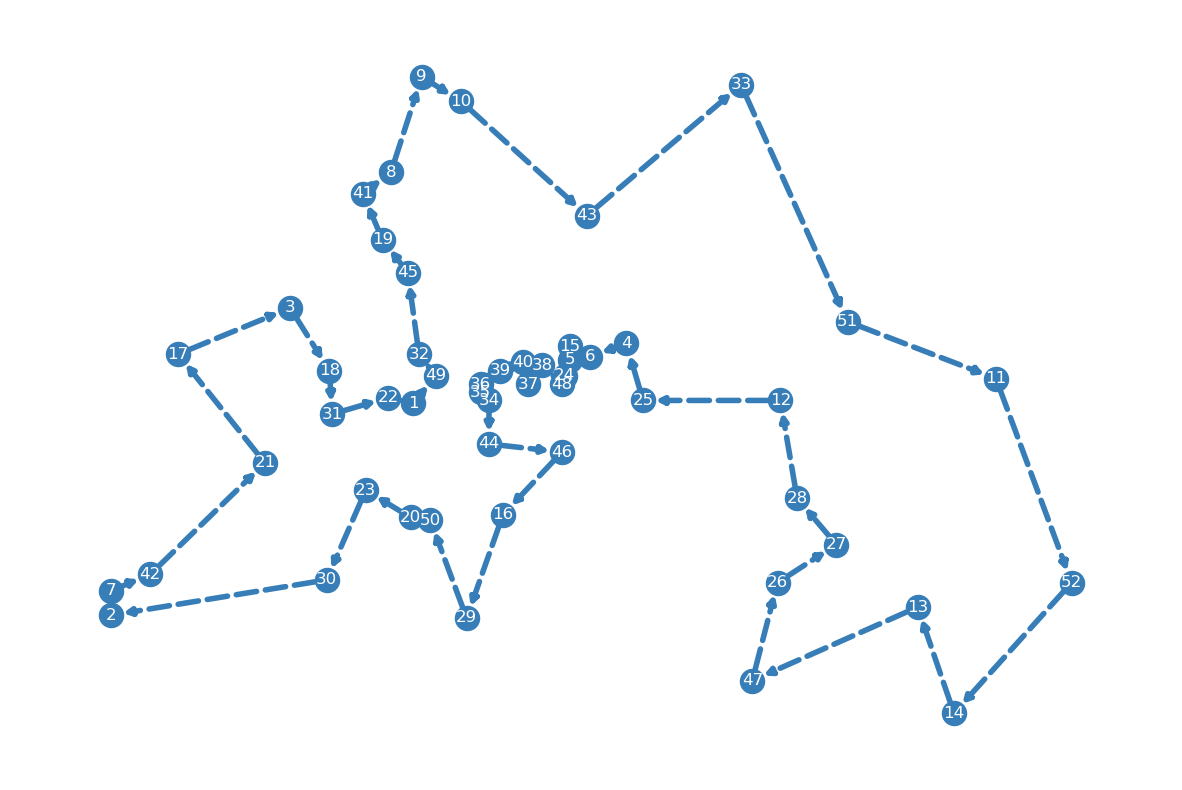

In [8]:
#| label: fig-tsp-berlin52-sol
#| fig-cap: Optimal tour of the *berlin52* instance
visualize_tsp('berlin52')

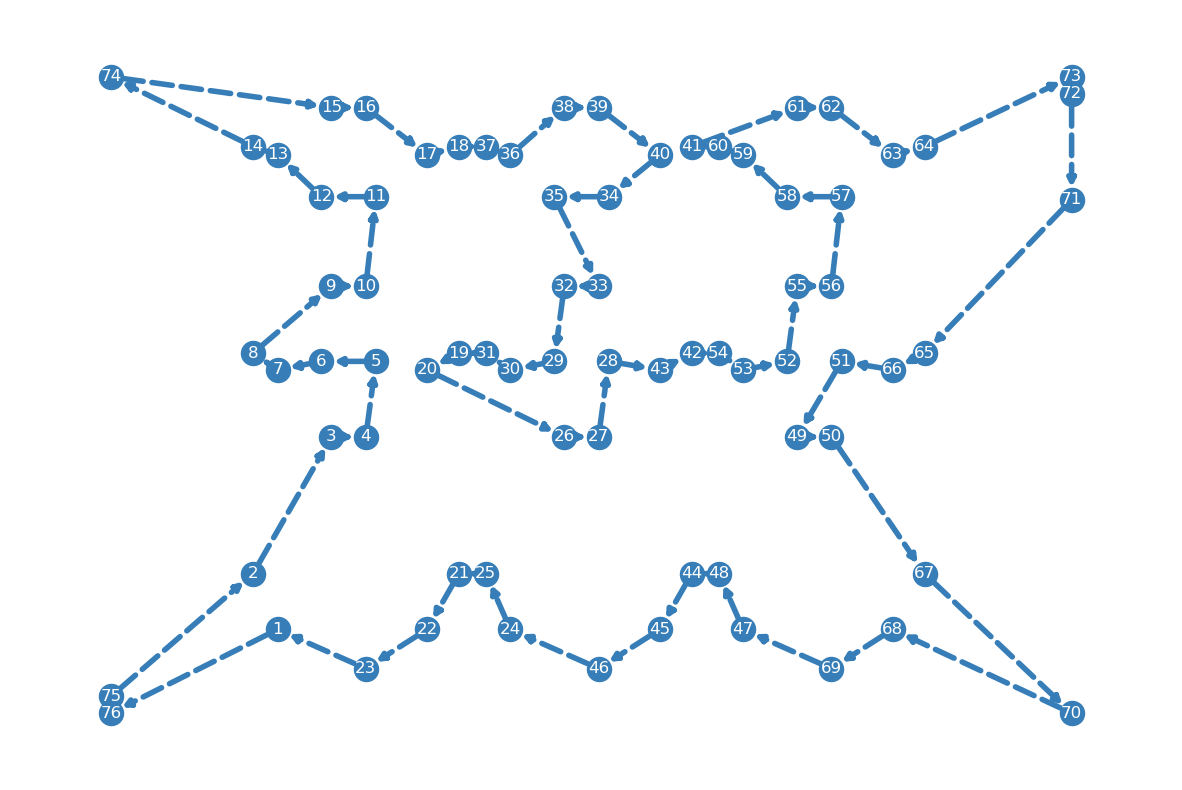

In [9]:
#| label: fig-tsp-pr76-sol
#| fig-cap: Optimal tour of the *pr76* instance
visualize_tsp('pr76')

## Problem Description

Let $\mathcal{G} = (\mathcal{V}, \mathcal{A})$ be an undirected complete graph, where $V = \{1, 2, \cdots, n\}$ represents a set of $n$ cities or vertices, and $\mathcal{A} = \{(i, j)\ |\ i, j \in \mathcal{V}, i \neq j\}$ represents the set of edges connecting these cities. 
The edges in $\mathcal{A}$ have weights or distances associated with them, $c_{ij}$, representing the distances or costs to travel between pairs of cities.

The objective of the TSP is to find the shortest possible closed tour that visits each city in $\mathcal{V}$ exactly once and returns to the starting city, while obeying the following constraints:

- Each city must be visited exactly once: The tour must include all the cities in $\mathcal{V}$, and each city must be visited exactly once during the tour.
- The tour must be closed: The last city visited in the tour must be the same as the starting city, forming a closed loop.

## Model 1 - DFJ

The first formulation was proposed by @dantzig_solution_1954.
It uses the following decision variables:

- $x_{ij}$: a binary variable that equals 1 if arc $(i, j) \in \mathcal{A}$ shows up in the optimal solution, 0 otherwise

We can state the model as follows:

\begin{align}
\text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{tsp1-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{V},\  j \neq i} x_{ij} = 1, \ \forall i \in \mathcal{V} \label{tsp1-cons1} \\
&\quad \sum_{i \in \mathcal{V}, \ i \neq j} x_{ij} = 1, \ \forall j \in \mathcal{V} \label{tsp1-cons2}\\
&\quad 
\begin{split}
    & \sum_{i, j \in S, \ (i, j) \in \mathcal{A}} x_{ij} \leq |S| - 1,\\
    &\qquad \forall S \subset \mathcal{V}, \ 2 \leq |S| \leq n - 2 
\end{split}
\label{tsp1-cons3}  \\
&\quad x_{ij} \in \{0, 1\}, \ \forall (i, j) \in \mathcal{A} \label{tsp1-cons4}
\end{align}

This specific TSP formulation aims to find the optimal route with the shortest total distance. 
To ensure that each node is visited exactly once, constraints \eqref{tsp1-cons1} and \eqref{tsp1-cons2}, also known as *degree constraints*, are used. 
Another set of constraints \eqref{tsp1-cons3}, called subtour elimination constraints, ensure that the solution does not contain any subtours. 
Subtours are smaller cycles within the larger route that violate the requirement of visiting each city exactly once. Two examples of solutions with subtours are shown in figures @fig-subtour1 and @fig-subtour2. While these solutions satisfy the degree constraints, they violate the subtour elimination constraints. A subtour contains the same number of edges (or arcs) as nodes, so limiting the number of edges to be less than the number of nodes can help to eliminate subtours.
Furthermore, because of the presence of degree constraints, subtours with only one node cannot exist, and similarly, subtours with $n-1$ nodes are also impossible. Therefore, it is acceptable to define the subtour elimination constraints only for subtours that contain between 2 and $n-2$ nodes.

```{mermaid}
%%| label: fig-subtour1
%%| fig-cap: Subtour with 2 nodes

flowchart LR
    1((1)) --> 2((2))
    2 --> 3((3))
    3 --> 4((4))
    4 --> 7((7))
    7 --> 1
    5((5)) --> 6((6))
    6 --> 5
```

```{mermaid}
%%| label: fig-subtour2
%%| fig-cap: Subtour with 3 nodes
flowchart LR
    1((1)) --> 2((2))
    2 --> 3((3))
    3 --> 7((7))
    7 --> 1
    4((4)) --> 5((5)) 
    5 --> 6((6))
    6 --> 4
```

An equivalent way of constraints \eqref{tsp1-cons3} is

\begin{align}
    \sum_{i \in S}\sum_{j \notin S} x_{ij} \geq 1, \ \forall S \subset \mathcal{V}, \ 2 \leq |S| \leq n - 2 \label{tsp1-cons5}
\end{align}

To understand this, observe that the value of $|S|$ can be calculated as the sum of two terms: the sum of the decision variables $x_{ij}$ for all edges $(i,j)$ that are included in the subset, and the sum of the decision variables $x_{ij}$ for all edges that cross the boundary of the subtour, that is, $|S| = \sum_{i, j \in S, \ (i, j) \in \mathcal{A}} x_{ij} +  \sum_{i \in S}\sum_{j \notin S} x_{ij}$. This means that the constraints \eqref{tsp1-cons3} and \eqref{tsp1-cons5} are interchangeable, as they represent the same condition in different forms.

To simplify the implementation of different TSP formulations that will be presented in the following sections, we have created a base class called `TspModel` in the code below. 
This class contains the instance information that needs to be solved, as well as several helper functions.
Within the class definition, the attribute `_node_list` holds the list of nodes that must be visited by the TSP tour.
The attribute `_node_coords` is a dictionary that stores the location information for each node.
Finally, the attribute `_distance` is another dictionary that provides the distance between any pair of nodes.
The `read_inputs()` function, defined between lines 15 and 31, takes a TSP problem instance and extracts the necessary information for solving the problem later.
The `get_combinations()` function, defined between lines 33 and 34, generates all possible combinations of nodes with the specified size.

In [10]:
from typing import Dict, List
from itertools import combinations
import tsplib95

class TspModel:
    """base class for TSP models
    """
    
    def __init__(self, name: str):
        self._name: str = name
        self._node_list: List[int] = None
        self._node_coords: Dict[int, List[float, float]] = None
        self._distance: Dict[int, Dict[int, int]] = None
        
    def read_inputs(self, instance_file: str) -> None:
        problem = tsplib95.load(instance_file)

        node_coords = problem.node_coords
        self._node_coords = {
            id: node_coords[id]
            for id in node_coords
        }
        self._node_list = list(node_coords.keys())
        
        self._distance = {}
        for i in self._node_list:
            dist = {
                j: problem.get_weight(i, j)
                for j in self._node_list
            }
            self._distance[i] = dist

    def get_combinations(self, size):
        return list(combinations(self._node_list, size))
        
    @property
    def name(self): return self._name
    
    @property
    def num_nodes(self): return len(self._node_coords)

To implement the TSP model using OR-Tools, we define the `TspModelV1` class that inherits from the base class `TspModel`. The constructor initializes a solver object and defines attributes to store decision variables and the optimal solution. The `_create_variables()` function creates binary decision variables for every arc in the problem, while the `_create_objective()` function calculates the total traveling cost. Degree constraints are defined in the `_create_degree_constraints()` function, while the subtour elimination constraints are defined in the `_create_subtour_elimination_constraints()` function. The `build_model()` function needs to be called before optimize() to construct the model.

In [25]:
from itertools import product
from ortools.linear_solver import pywraplp

class TspModelV1(TspModel):
    
    def __init__(self, name='Tspmodel_v1'):
        super().__init__(name)
        
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        self._opt_obj = None
        self._opt_x = None
        self._opt_route = None
    
    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_degree_constraints()
        self._create_subtour_elimination_constraints()
    
    def optimize(self, enable_output: bool):
        if enable_output: self._solver.EnableOutput()
        status = self._solver.Solve()
        if status is pywraplp.Solver.OPTIMAL:
            self._retrieve_opt_solution()
            self._retrieve_opt_route()
    
    def _create_variables(self):
        self._var_x = {}
        for i in self._node_list:
            self._var_x[i] = {
                j: self._solver.BoolVar('x_{i, j}')
                for j in self._node_list
                if j != i
            }
    
    def _create_objective(self):
        node_list = self._node_list
        expr = [self._distance[i][j] * self._var_x[i][j]
                for i, j in product(node_list, node_list)
                if i != j]
        self._solver.Minimize(self._solver.Sum(expr))
        
    def _create_degree_constraints(self):
        for i in self._node_list:
            out_expr = [self._var_x[i][j]
                    for j in self._node_list
                    if j != i
                    ]
            in_expr = [self._var_x[j][i]
                        for j in self._node_list
                        if j != i
                    ]
            self._solver.Add(self._solver.Sum(out_expr) == 1)
            self._solver.Add(self._solver.Sum(in_expr) == 1)
    
    def _create_subtour_elimination_constraints(self):
        num_nodes = self.num_nodes
        for size in range(2, num_nodes - 1):
            combinations = self.get_combinations(size)
            for comb in combinations:
                expr = [self._var_x[i][j]
                        for i, j in product(comb, comb)
                        if i != j]
                self._solver.Add(self._solver.Sum(expr) <= 
                                len(comb) - 1)
    
    def _retrieve_opt_solution(self):
        self._opt_obj = float(self._solver.Objective().Value())
        self._opt_x = {}
        for i in self._node_list:
            self._opt_x[i] = {
                j: round(self._var_x[i][j].solution_value())
                for j in self._node_list
                if j != i
            }
            
        print(f'optimal value = {self._opt_obj:.2f}')
    
    def _retrieve_opt_route(self):
        self._opt_route = []
        route_start = list(self._opt_x.keys())[0]
        edge_start = route_start
        while True:
            for n in self._opt_x[edge_start]:
                if self._opt_x[edge_start][n] == 0: continue
                
                edge_end = n
                self._opt_route.append((edge_start, edge_end))
                break
            
            if edge_end == route_start: break
            edge_start = edge_end
            
    def show_opt_route(self):
        TspVisualizer.show(self._node_coords, self._opt_route)
        
        
    def show_model_info(self):
        print(f"Number of variables: {self._solver.NumVariables()}")
        print(f"Number of constraints: {self._solver.NumConstraints()}")

Now we use the `TspModelV1` class to solve the *burma14* instance and plots the optimal solution found by the OR-Tools in @fig-tsp-model1-burma14-sol.

Number of variables: 182
Number of constraints: 16382
optimal value = 3323.0


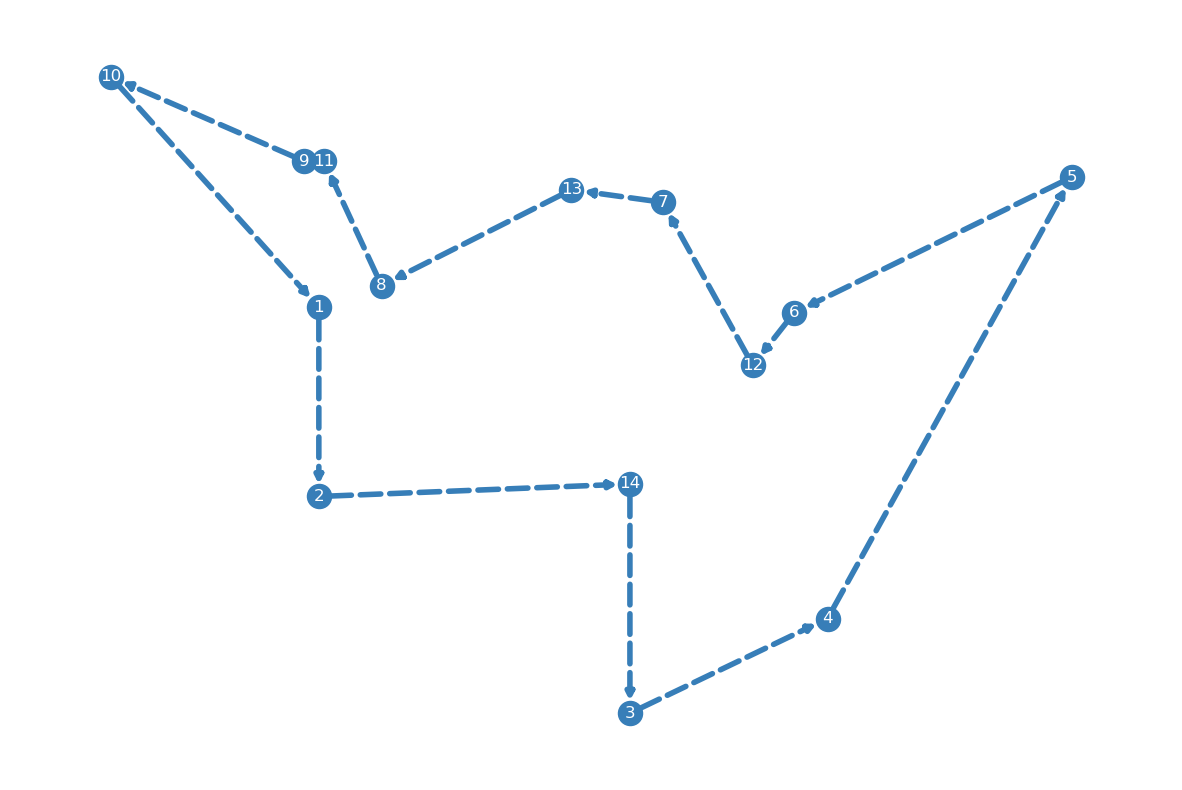

In [17]:
#| label: fig-tsp-model1-burma14-sol
#| fig-cap: Optimal route for the *burma14* instance

instance = './data/tsp/burma14.tsp'

model_v1 = TspModelV1()
model_v1.read_inputs(instance_file=instance)
model_v1.build_model()
model_v1.show_model_info()
model_v1.optimize(False)
model_v1.show_opt_route()

## Model 2 - MTZ

In this formulation, an alternative way of modeling the subtour elimination constraints was proposed by @miller_integer_1960.
The model uses two types of decision variables:

- $x_{ij}$: a binary variable that equals 1 if arc $(i, j) \in \mathcal{A}$ shows up in the optimal solution, 0 otherwise
- $u_i$: a continuous variable for $i \in \mathcal{V} \backslash \{1\}$

The complete formulation is given below.

\begin{align}
\text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{tsp2-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{V},\  j \neq i} x_{ij} = 1, \ \forall i \in \mathcal{V} \label{tsp2-cons1} \\
&\quad \sum_{i \in \mathcal{V}, \ i \neq j} x_{ij} = 1, \ \forall j \in \mathcal{V} \label{tsp2-cons2}\\
&\quad 
\begin{split}
    &u_i - u_j + (n - 1) x_{ij} \leq n - 2, \\
    &\qquad \forall i, j \in \{2, \cdots, n\}, i \neq j
\end{split}
\label{tsp2-cons4} \\
&\quad 1 \leq n_i \leq n - 1, i = 2, \cdots, n \label{tsp2-cons5}
\end{align}

In [29]:
from itertools import product
from ortools.linear_solver import pywraplp

class TspModelV2(TspModel):
    
    def __init__(self, name='Tspmodel_v2'):
        super().__init__(name)
        
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        self._var_u = None
        self._opt_obj = None
        self._opt_x = None
        self._opt_route = None
    
    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_degree_constraints()
        self._create_subtour_elimination_constraints()
    
    def optimize(self, enable_output: bool):
        if enable_output: self._solver.EnableOutput()
        status = self._solver.Solve()
        if status is pywraplp.Solver.OPTIMAL:
            self._retrieve_opt_solution()
            self._retrieve_opt_route()
    
    def _create_variables(self):
        self._var_x = {}
        for i in self._node_list:
            self._var_x[i] = {
                j: self._solver.BoolVar(f'x_{i, j}')
                for j in self._node_list
                if j != i
            }
        
        self._var_u = {
            i: self._solver.NumVar(1, self.num_nodes, f'v_{i}')
            for i in self._node_list
            if i != 1
        }
    
    def _create_objective(self):
        node_list = self._node_list
        expr = [self._distance[i][j] * self._var_x[i][j]
                for i, j in product(node_list, node_list)
                if i != j]
        self._solver.Minimize(self._solver.Sum(expr))
        
    def _create_degree_constraints(self):
        for i in self._node_list:
            out_expr = [self._var_x[i][j]
                    for j in self._node_list
                    if j != i
                    ]
            in_expr = [self._var_x[j][i]
                        for j in self._node_list
                        if j != i
                    ]
            self._solver.Add(self._solver.Sum(out_expr) == 1)
            self._solver.Add(self._solver.Sum(in_expr) == 1)
    
    def _create_subtour_elimination_constraints(self):
        num_nodes = self.num_nodes
        for i, j in product(self._node_list, self._node_list):
            if i == j: continue
            if i == 1 or j == 1: continue
            self._solver.Add(self._var_u[i] - 
                            self._var_u[j] +
                            (num_nodes - 1) * self._var_x[i][j] <=
                            num_nodes - 2)
    
    def _retrieve_opt_solution(self):
        self._opt_obj = float(self._solver.Objective().Value())
        self._opt_x = {}
        for i in self._node_list:
            self._opt_x[i] = {
                j: round(self._var_x[i][j].solution_value())
                for j in self._node_list
                if j != i
            }
            
        print(f'optimal value = {self._opt_obj:.2f}')
    
    def _retrieve_opt_route(self):
        self._opt_route = []
        route_start = list(self._opt_x.keys())[0]
        edge_start = route_start
        while True:
            for n in self._opt_x[edge_start]:
                if self._opt_x[edge_start][n] == 0: continue
                
                edge_end = n
                self._opt_route.append((edge_start, edge_end))
                break
            
            if edge_end == route_start: break
            edge_start = edge_end
            
    def show_opt_route(self):
        TspVisualizer.show(self._node_coords, self._opt_route)
        
        
    def show_model_info(self):
        print(f"Number of variables: {self._solver.NumVariables()}")
        print(f"Number of constraints: {self._solver.NumConstraints()}")

Number of variables: 195
Number of constraints: 184
optimal value = 3323.00


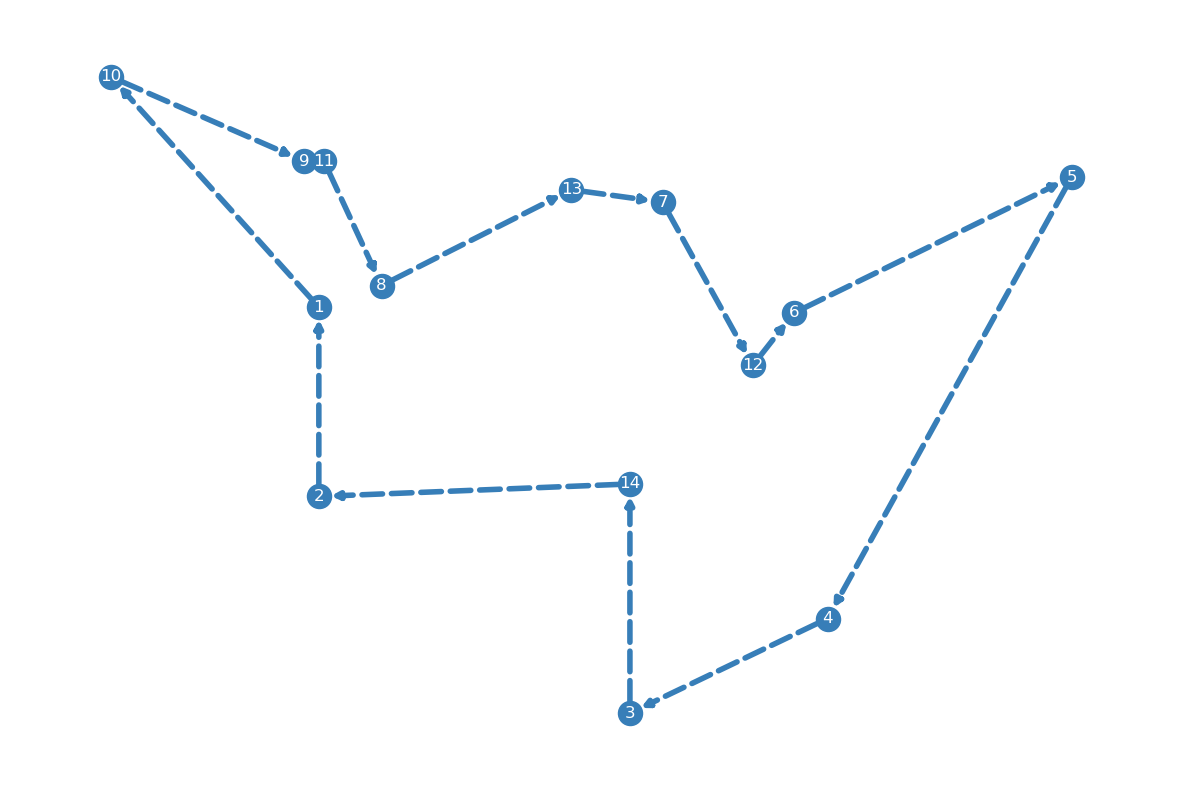

In [30]:
#| label: fig-tsp-model2-burma14-sol
#| fig-cap: Optimal route for the *burma14* instance

instance = './data/tsp/burma14.tsp'

model_v2 = TspModelV2()
model_v2.read_inputs(instance_file=instance)
model_v2.build_model()
model_v2.show_model_info()
model_v2.optimize(False)
model_v2.show_opt_route()

Number of variables: 483
Number of constraints: 464
optimal value = 7013.0


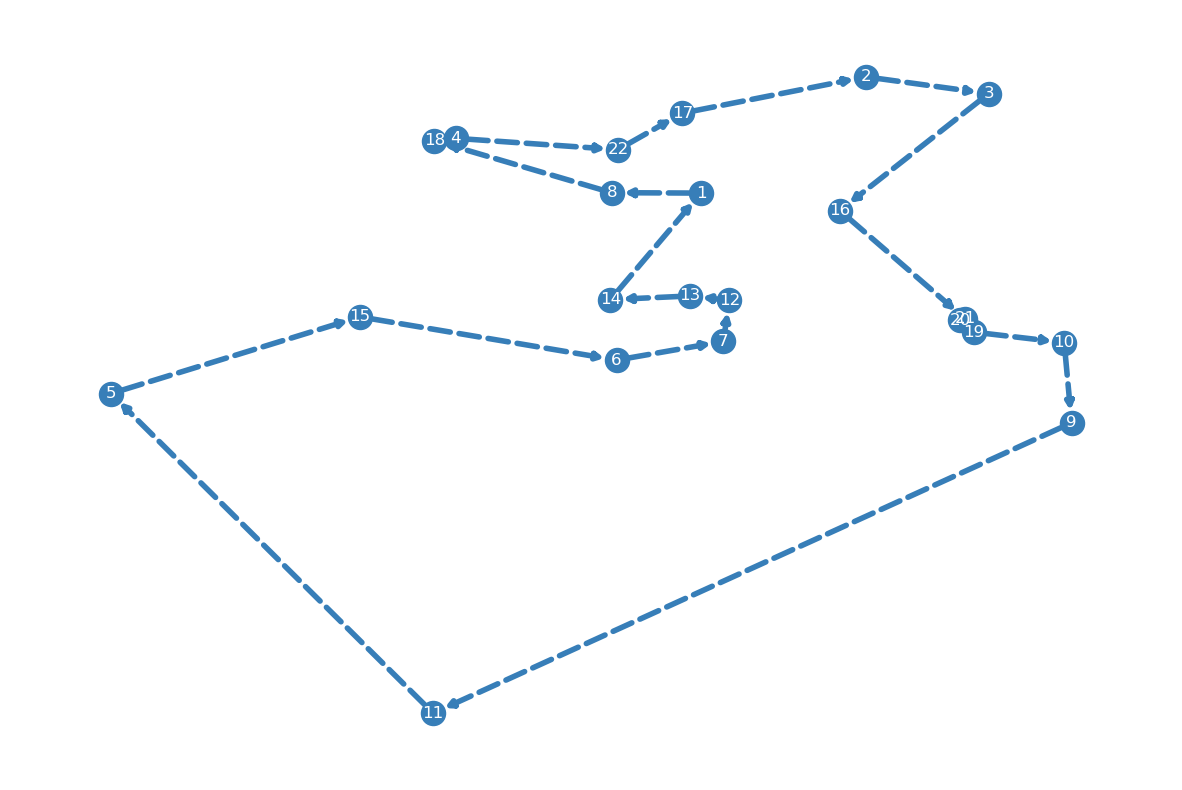

In [27]:
#| label: fig-tsp-model2-ulysses22-sol
#| fig-cap: Optimal route for the *ulysses22* instance

instance = './data/tsp/ulysses22.tsp'

model_v2 = TspModelV2()
model_v2.read_inputs(instance_file=instance)
model_v2.build_model()
model_v2.show_model_info()
model_v2.optimize(False)
model_v2.show_opt_route()

## Model 3 - Single Commodity Flow




The model uses two types of decision variables:

- $x_{ij}$: a binary variable that equals 1 if arc $(i, j) \in \mathcal{A}$ shows up in the optimal solution, 0 otherwise
- $y_{ij}$: a continuous variable representing the flow on arc $(i, j) \in \mathcal{A}$

The complete formulation is given below.

\begin{align}
\text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{tsp3-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{V},\  j \neq i} x_{ij} = 1, \ \forall i \in \mathcal{V} \label{tsp3-cons1} \\
&\quad \sum_{i \in \mathcal{V}, \ i \neq j} x_{ij} = 1, \ \forall j \in \mathcal{V} \label{tsp3-cons2}\\
&\quad y_{ij} \leq (n - 1) x_{ij}, \ \forall (i, j) \in \mathcal{A} \label{tsp3-cons3} \\
&\quad \sum_{j \in \mathcal{V}\backslash \{1\}} y_{1j} = n - 1, \label{tsp3-cons4} \\
&\quad \sum_{i \in \mathcal{V}\backslash \{j\}} y_{ij} - \sum_{k \in \mathcal{V}\backslash \{j\}} y_{jk} = 1, \ \forall j \in \mathcal{V}\backslash \{1\} \label{tsp3-cons5}\\
&\quad 1 \leq n_i \leq n - 1, i = 2, \cdots, n \label{tsp3-cons6} \\
&\quad y_{ij} \geq 0, \ \forall (i, j) \in \mathcal{A} \label{tsp3-cons7}
\end{align}

In [31]:
from itertools import product
from ortools.linear_solver import pywraplp

class TspModelV3(TspModel):
    
    def __init__(self, name='Tspmodel_v3'):
        super().__init__(name)
        
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        self._var_y = None
        self._opt_obj = None
        self._opt_x = None
        self._opt_route = None
    
    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_degree_constraints()
        self._create_subtour_elimination_constraints()
    
    def optimize(self, enable_output: bool):
        if enable_output: self._solver.EnableOutput()
        status = self._solver.Solve()
        if status is pywraplp.Solver.OPTIMAL:
            self._retrieve_opt_solution()
            self._retrieve_opt_route()
    
    def _create_variables(self):
        self._var_x = {}
        for i in self._node_list:
            self._var_x[i] = {
                j: self._solver.BoolVar(f'x_{i, j}')
                for j in self._node_list
                if j != i
            }
        
        infinity = self._solver.Infinity()
        self._var_y = {}
        for i in self._node_list:
            self._var_y[i] = {
                j: self._solver.NumVar(0, infinity, f'y_{i, j}')
                for j in self._node_list
                if j != i
            }
        
    def _create_objective(self):
        node_list = self._node_list
        expr = [self._distance[i][j] * self._var_x[i][j]
                for i, j in product(node_list, node_list)
                if i != j]
        self._solver.Minimize(self._solver.Sum(expr))
        
    def _create_degree_constraints(self):
        for i in self._node_list:
            out_expr = [self._var_x[i][j]
                    for j in self._node_list
                    if j != i
                    ]
            in_expr = [self._var_x[j][i]
                        for j in self._node_list
                        if j != i
                    ]
            self._solver.Add(self._solver.Sum(out_expr) == 1)
            self._solver.Add(self._solver.Sum(in_expr) == 1)
    
    def _create_subtour_elimination_constraints(self):
        num_nodes = self.num_nodes
        for i, j in product(self._node_list, self._node_list):
            if i == j: continue
            self._solver.Add(self._var_y[i][j] <= (num_nodes - 1) * self._var_x[i][j])

        expr = [self._var_y[1][j] for j in self._node_list if j != 1]
        self._solver.Add(self._solver.Sum(expr) == num_nodes - 1)

        for j in self._node_list:
            if j == 1: continue
            expr1 = [self._var_y[i][j] for i in self._node_list if i != j]
            expr2 = [self._var_y[j][k] for k in self._node_list if k != j]
            self._solver.Add(self._solver.Sum(expr1) - self._solver.Sum(expr2) == 1)
        
    
    def _retrieve_opt_solution(self):
        self._opt_obj = float(self._solver.Objective().Value())
        self._opt_x = {}
        for i in self._node_list:
            self._opt_x[i] = {
                j: round(self._var_x[i][j].solution_value())
                for j in self._node_list
                if j != i
            }
            
        print(f'optimal value = {self._opt_obj:.2f}')
    
    def _retrieve_opt_route(self):
        self._opt_route = []
        route_start = list(self._opt_x.keys())[0]
        edge_start = route_start
        while True:
            for n in self._opt_x[edge_start]:
                if self._opt_x[edge_start][n] == 0: continue
                
                edge_end = n
                self._opt_route.append((edge_start, edge_end))
                break
            
            if edge_end == route_start: break
            edge_start = edge_end
            
    def show_opt_route(self):
        TspVisualizer.show(self._node_coords, self._opt_route)
        
        
    def show_model_info(self):
        print(f"Number of variables: {self._solver.NumVariables()}")
        print(f"Number of constraints: {self._solver.NumConstraints()}")

Number of variables: 364
Number of constraints: 224
optimal value = 3323.00


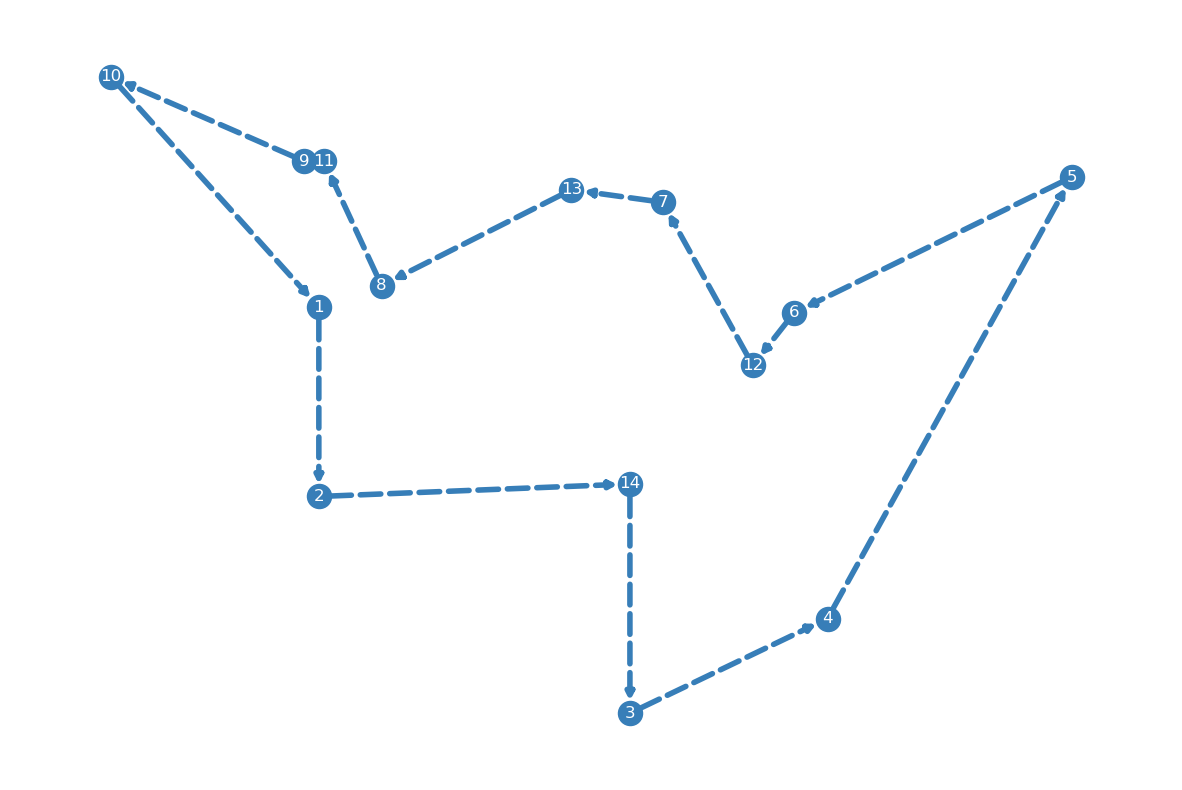

In [32]:
#| label: fig-tsp-model3-burma14-sol
#| fig-cap: Optimal route for the *burma14* instance

instance = './data/tsp/burma14.tsp'

model_v3 = TspModelV3()
model_v3.read_inputs(instance_file=instance)
model_v3.build_model()
model_v3.show_model_info()
model_v3.optimize(False)
model_v3.show_opt_route()

Number of variables: 924
Number of constraints: 528
optimal value = 7013.00


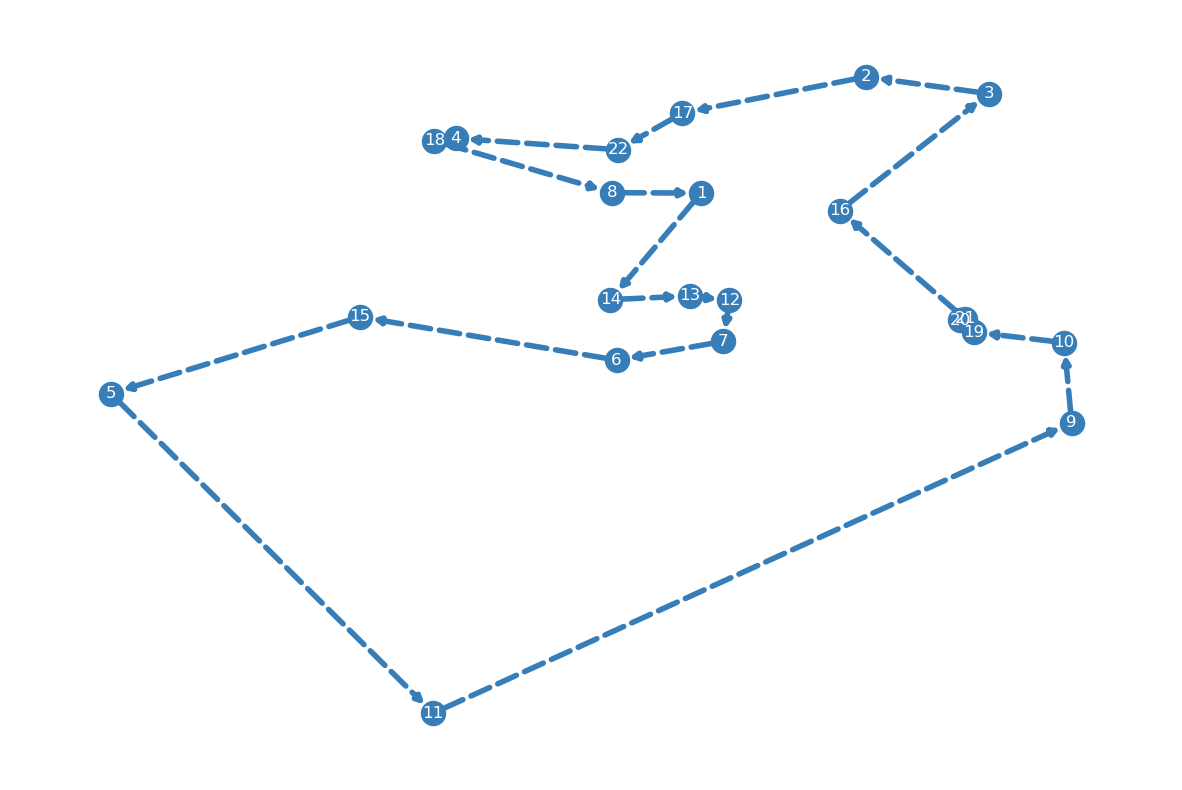

In [33]:
#| label: fig-tsp-model3-ulysses22-sol
#| fig-cap: Optimal route for the *ulysses22* instance

instance = './data/tsp/ulysses22.tsp'

model_v3 = TspModelV3()
model_v3.read_inputs(instance_file=instance)
model_v3.build_model()
model_v3.show_model_info()
model_v3.optimize(False)
model_v3.show_opt_route()

Number of variables: 5304
Number of constraints: 2808
optimal value = 7542.00


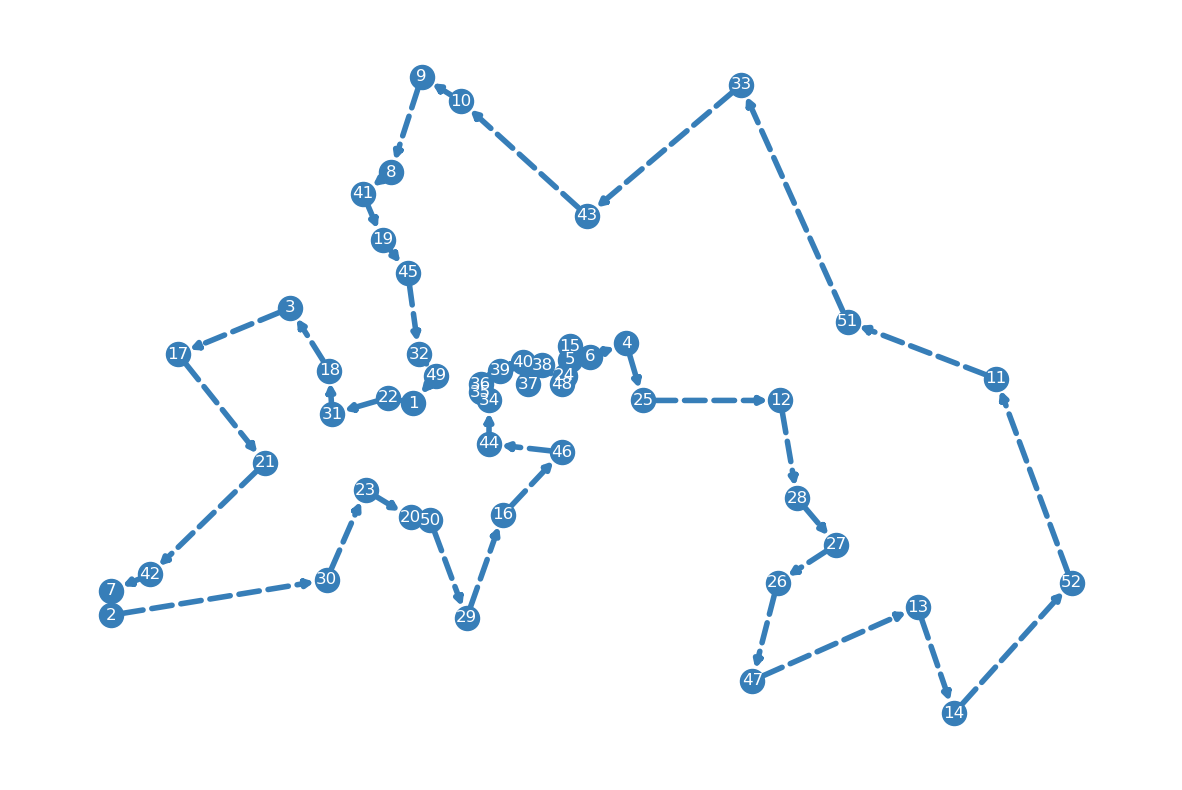

In [34]:
#| label: fig-tsp-model3-berlin52-sol
#| fig-cap: Optimal route for the *berlin52* instance

instance = './data/tsp/berlin52.tsp'

model_v3 = TspModelV3()
model_v3.read_inputs(instance_file=instance)
model_v3.build_model()
model_v3.show_model_info()
model_v3.optimize(False)
model_v3.show_opt_route()

Number of variables: 11400
Number of constraints: 5928
optimal value = 108159.00


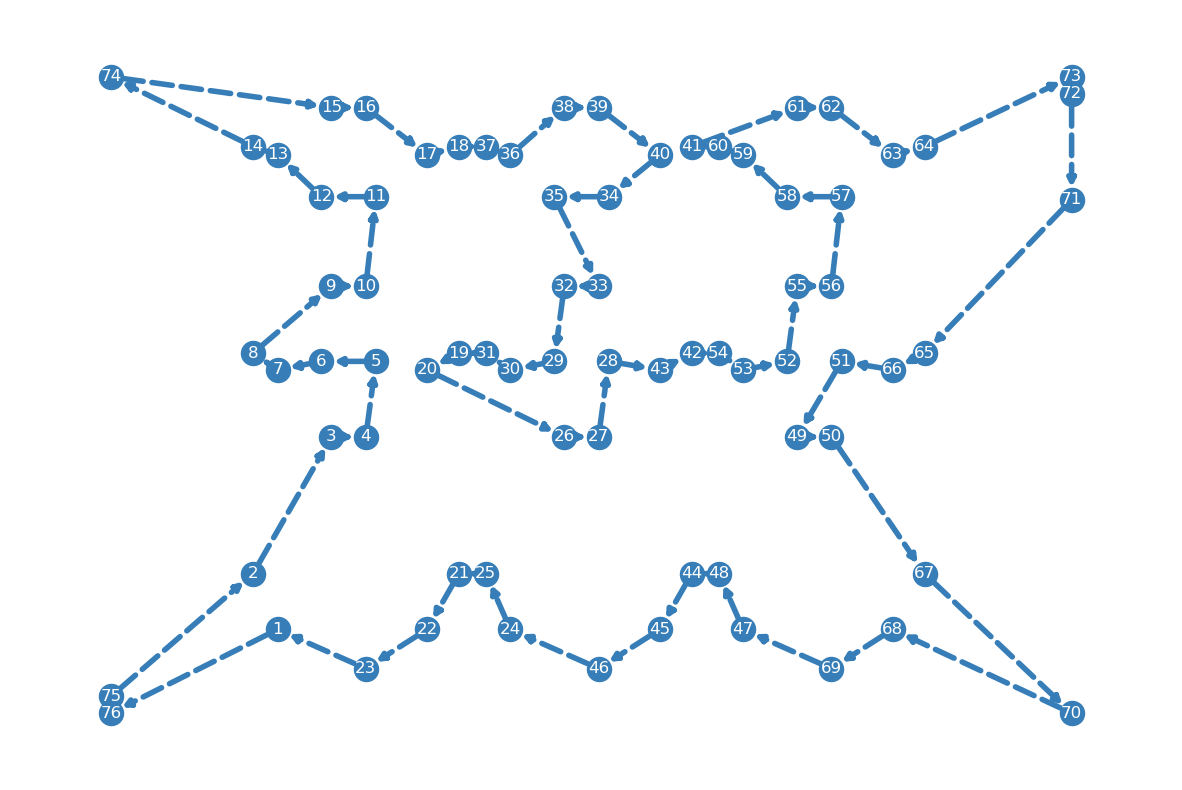

In [35]:
#| label: fig-tsp-model3-pr76-sol
#| fig-cap: Optimal route for the *pr76* instance

instance = './data/tsp/pr76.tsp'

model_v3 = TspModelV3()
model_v3.read_inputs(instance_file=instance)
model_v3.build_model()
model_v3.show_model_info()
model_v3.optimize(False)
model_v3.show_opt_route()

## Model 4 - Two Commodity Flow



The model uses three types of decision variables:

- $x_{ij}$: a binary variable that equals 1 if arc $(i, j) \in \mathcal{A}$ shows up in the optimal solution, 0 otherwise
- $y_{ij}$: a continuous variable representing the flow of commodity 1 on arc $(i, j) \in \mathcal{A}$
- $z_{ij}$: a continuous variable representing the flow of commodity 2 on arc $(i, j) \in \mathcal{A}$

The complete formulation is given below.

\begin{align}
\text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{tsp4-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{V},\  j \neq i} x_{ij} = 1, \ \forall i \in \mathcal{V} \label{tsp4-cons1} \\
&\quad \sum_{i \in \mathcal{V}, \ i \neq j} x_{ij} = 1, \ \forall j \in \mathcal{V} \label{tsp4-cons2}\\
&\quad \sum_{j \in \mathcal{V}\backslash\{1\}} (y_{1j} - y_{j1}) = n - 1 \label{tsp4-cons4} \\
&\quad \sum_{j \in \mathcal{V}, j \neq i} (y_{ij} - y_{ji}) = -1, \ \forall i \in \mathcal{V} \backslash \{1\} \\
&\quad \sum_{j \in \mathcal{V}\backslash\{1\}} (z_{1j} - z_{j1}) = -(n - 1) \label{tsp4-cons6} \\
&\quad \sum_{j \in \mathcal{V}, j \neq i} (z_{ij} - z_{ji}) = 1, \ \forall i \in \mathcal{V} \backslash \{1\} \\
&\quad \sum_{j \in \mathcal{V} , j \neq i} (y_{ij} + z_{ij}) = n - 1, \ \forall i \in \mathcal{V} \\
&\quad y_{ij} + z_{ij} = (n - 1) x_{ij}, \ \forall (i, j) \in \mathcal{A} \\
&\quad 1 \leq n_i \leq n - 1, i = 2, \cdots, n \label{tsp4-cons10} \\
&\quad y_{ij} \geq 0, \ \forall (i, j) \in \mathcal{A}  \\
&\quad z_{ij} \geq 0, \ \forall (i, j) \in \mathcal{A} 
\end{align}

In [38]:
from itertools import product
from ortools.linear_solver import pywraplp

class TspModelV4(TspModel):
    
    def __init__(self, name='Tspmodel_v4'):
        super().__init__(name)
        
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        self._var_y = None
        self._var_z = None
        self._opt_obj = None
        self._opt_x = None
        self._opt_route = None
    
    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_degree_constraints()
        self._create_subtour_elimination_constraints()
    
    def optimize(self, enable_output: bool):
        if enable_output: self._solver.EnableOutput()
        status = self._solver.Solve()
        if status is pywraplp.Solver.OPTIMAL:
            self._retrieve_opt_solution()
            self._retrieve_opt_route()
    
    def _create_variables(self):
        self._var_x = {}
        for i in self._node_list:
            self._var_x[i] = {
                j: self._solver.BoolVar(f'x_{i, j}')
                for j in self._node_list
                if j != i
            }
        
        infinity = self._solver.Infinity()
        self._var_y = {}
        for i in self._node_list:
            self._var_y[i] = {
                j: self._solver.NumVar(0, infinity, f'y_{i, j}')
                for j in self._node_list
                if j != i
            }
        
        self._var_z = {}
        for i in self._node_list:
            self._var_z[i] = {
                j: self._solver.NumVar(0, infinity, f'z_{i, j}')
                for j in self._node_list
                if j != i
            }
        
    def _create_objective(self):
        node_list = self._node_list
        expr = [self._distance[i][j] * self._var_x[i][j]
                for i, j in product(node_list, node_list)
                if i != j]
        self._solver.Minimize(self._solver.Sum(expr))
        
    def _create_degree_constraints(self):
        for i in self._node_list:
            out_expr = [self._var_x[i][j]
                    for j in self._node_list
                    if j != i
                    ]
            in_expr = [self._var_x[j][i]
                        for j in self._node_list
                        if j != i
                    ]
            self._solver.Add(self._solver.Sum(out_expr) == 1)
            self._solver.Add(self._solver.Sum(in_expr) == 1)
    
    def _create_subtour_elimination_constraints(self):
        num_nodes = self.num_nodes
        expr1 = [self._var_y[1][j] for j in self._node_list if j != 1]
        expr2 = [self._var_y[j][1] for j in self._node_list if j != 1]
        self._solver.Add(self._solver.Sum(expr1) - self._solver.Sum(expr2) == num_nodes - 1)

        for i in self._node_list:
            if i == 1: continue
            expr1 = [self._var_y[i][j] for j in self._node_list if j != i]
            expr2 = [self._var_y[j][i] for j in self._node_list if j != i]
            self._solver.Add(self._solver.Sum(expr1) - self._solver.Sum(expr2) == -1)
            
        expr1 = [self._var_z[1][j] for j in self._node_list if j != 1]
        expr2 = [self._var_z[j][1] for j in self._node_list if j != 1]
        self._solver.Add(self._solver.Sum(expr1) - self._solver.Sum(expr2) == -num_nodes + 1)

        for i in self._node_list:
            if i == 1: continue
            expr1 = [self._var_z[i][j] for j in self._node_list if j != i]
            expr2 = [self._var_z[j][i] for j in self._node_list if j != i]
            self._solver.Add(self._solver.Sum(expr1) - self._solver.Sum(expr2) == 1)
        
        for i in self._node_list:
            expr1 = [self._var_y[i][j] for j in self._node_list if j != i]
            expr2 = [self._var_z[i][j] for j in self._node_list if j != i]
            self._solver.Add(self._solver.Sum(expr1) + self._solver.Sum(expr2) == num_nodes - 1)
        
        for i, j in product(self._node_list, self._node_list):
            if i == j: continue
            self._solver.Add(self._var_y[i][j] + self._var_z[i][j] == (num_nodes - 1) * self._var_x[i][j])
        
    
    def _retrieve_opt_solution(self):
        self._opt_obj = float(self._solver.Objective().Value())
        self._opt_x = {}
        for i in self._node_list:
            self._opt_x[i] = {
                j: round(self._var_x[i][j].solution_value())
                for j in self._node_list
                if j != i
            }
            
        print(f'optimal value = {self._opt_obj:.2f}')
    
    def _retrieve_opt_route(self):
        self._opt_route = []
        route_start = list(self._opt_x.keys())[0]
        edge_start = route_start
        while True:
            for n in self._opt_x[edge_start]:
                if self._opt_x[edge_start][n] == 0: continue
                
                edge_end = n
                self._opt_route.append((edge_start, edge_end))
                break
            
            if edge_end == route_start: break
            edge_start = edge_end
            
    def show_opt_route(self):
        TspVisualizer.show(self._node_coords, self._opt_route)
        
        
    def show_model_info(self):
        print(f"Number of variables: {self._solver.NumVariables()}")
        print(f"Number of constraints: {self._solver.NumConstraints()}")

Number of variables: 546
Number of constraints: 252
optimal value = 3323.00


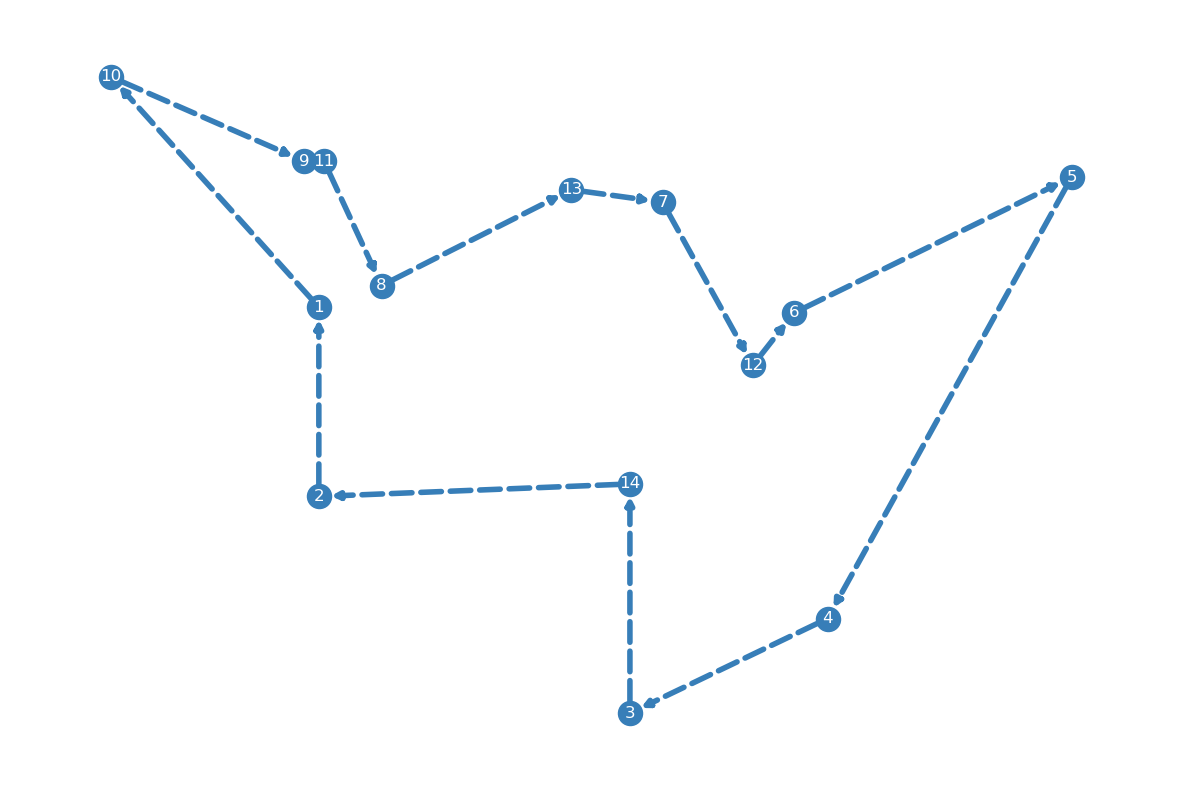

In [39]:
#| label: fig-tsp-model4-burma14-sol
#| fig-cap: Optimal route for the *burma14* instance

instance = './data/tsp/burma14.tsp'

model_v4 = TspModelV4()
model_v4.read_inputs(instance_file=instance)
model_v4.build_model()
model_v4.show_model_info()
model_v4.optimize(False)
model_v4.show_opt_route()

Number of variables: 7956
Number of constraints: 2912
optimal value = 7542.00


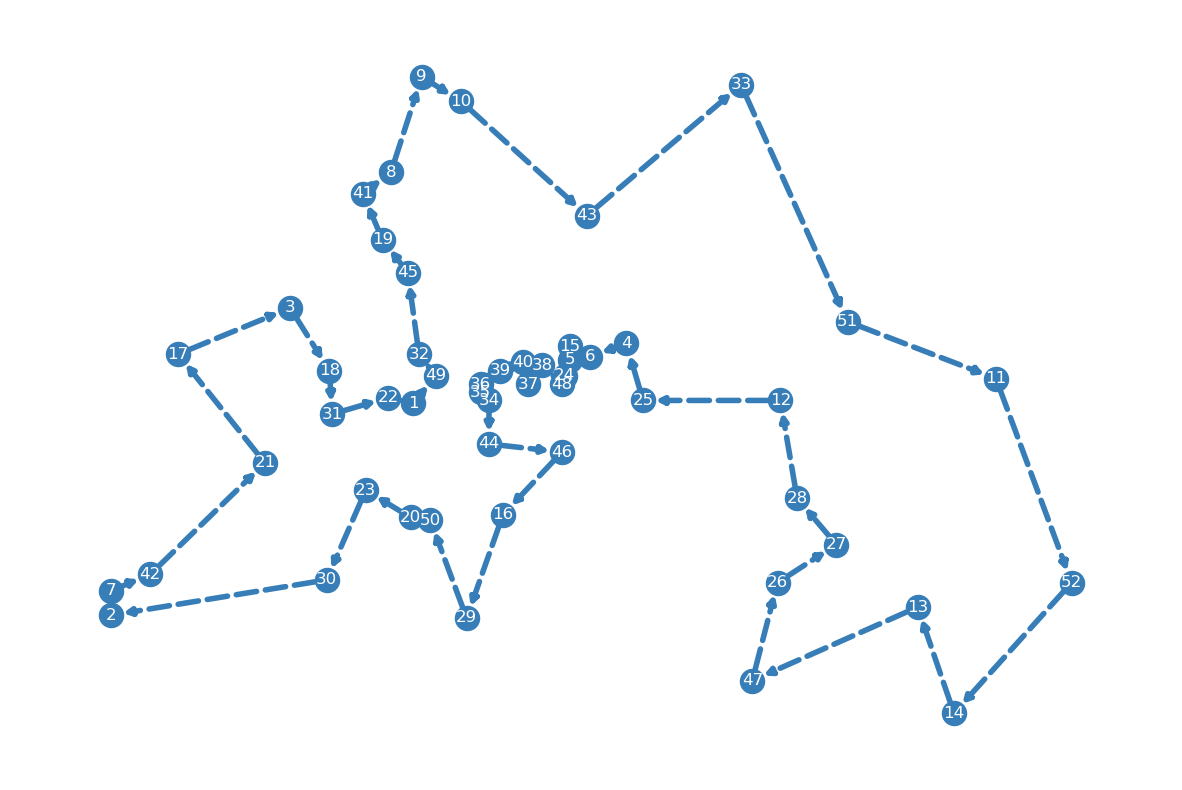

In [40]:
#| label: fig-tsp-model4-berlin52-sol
#| fig-cap: Optimal route for the *burma14* instance

instance = './data/tsp/berlin52.tsp'

model_v4 = TspModelV4()
model_v4.read_inputs(instance_file=instance)
model_v4.build_model()
model_v4.show_model_info()
model_v4.optimize(False)
model_v4.show_opt_route()

## Model 5 - Multi-Commodity Flow


The model uses two types of decision variables:

- $x_{ij}$: a binary variable that equals 1 if arc $(i, j) \in \mathcal{A}$ shows up in the optimal solution, 0 otherwise
- $y_{ij}^k$: a continuous variable representing the flow of commodity $k$ on arc $(i, j) \in \mathcal{A}$

The complete formulation is given below.

\begin{align}
\text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{tsp5-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{V},\  j \neq i} x_{ij} = 1, \ \forall i \in \mathcal{V} \label{tsp5-cons1} \\
&\quad \sum_{i \in \mathcal{V}, \ i \neq j} x_{ij} = 1, \ \forall j \in \mathcal{V} \label{tsp5-cons2}\\
&\quad  \label{tsp5-cons4} \\
&\quad 1 \leq n_i \leq n - 1, i = 2, \cdots, n \label{tsp5-cons5}
\end{align}